## Toxic Inventory Sites that are within 500 meters of a Water Source

#### Table of Contents  
 - [Read the rivers & state data files](#readrivers)
 - [Examine the dataframes](#examinedf)  
 - [Examine dataframe columns - using grouby() and stack()](#groupby)  
 - [Plot the dataframes](#plotdat1)   
   - [Zoom into plot](#zoomplot)  
 - [Information about dataframe columns](#infodat)  
   - [Unique Feature values with corrsponding F_Code](#fcode)  
   - [State column in the rivers dataframe contains more than expected](#examinestatecol)  
 - [Focus dataframes on one state](#focusstate)  
   - [Plot the new dataframe](#plotdat)  
 - [Top 20 longest rivers](#top20)
  - [Simplfied method for identifying longest rivers](#simplified)  
  - [Create a dataframe that only has the longest rivers in it (using: isin)](#findlongs)  
  - [Plot the longest rivers over the rivers](#plotlong)  
 - [Load toxic data inventory](#loadtoxic)  
 - [convert pandas DataFrame into a GeoPandas GeoDataFrame](#convertpandas)
 - [plot the GeoPandas dataframe](#plottoxic)
 - [Examine area of Kentucky](#examineKY)
 - [Create a "clipping mask" using the outline of state in state geodataframe](#clipmaskmain)
  - [check if the geom is not composed of both Polygon and Multipolygon types](#checkgeom2)
  - [create a polygon to be used as a clipping mask](#clipmask)
  - [intersect toxic inventory with state clipping mask](#intersectclip)
 - [Plot the new geo layers](#plotnewgeo)
 - [Prepare the data to measure distance](#measuredist)
 - [check the plot of the reprojected dataframes](#checkplot)
 - [Use GeoPandas .buffer() method to create a new column in the existing GeoDataFrame](#buffercolumn)
 - [make the new buffer column the active geometry to plot the data](#activategeom)
 - [Replot with 500 meter buffer circles](#buffcircles)
 - [Create Line Polygon Intersection](#intersect)
 - [Closeup look at buffer poly - line intersections](#closeup)
 - [Stats before the intersect and after](#stats)
 - [Build a list of unique streams that intersect with the buffer](#uniquestreamlist)
 - [Plot the identified stream portions that intersect with the buffer (in progress)](#plotportions)
 - [Design a function to streamline processing](#designfunction)
 

In [128]:
%matplotlib inline

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams

In [131]:
# change default figsize 
plt.rcParams['figure.figsize'] = (15, 12)

<a id='readrivers'></a>
#### Read the rivers & state data files

Rivers/Streams Data Source: [USA Detailed Streams](http://edu-esriroedu.opendata.arcgis.com/datasets/3428672decd64aeabcb8da15e9b749f0_0)  
OR  
https://nationalmap.gov/small_scale/atlasftp.html?openChapters=chpwater#chpwater

In [3]:
%%time
rivers_raw = gpd.read_file('data/streaml010g/streaml010g.shp')

CPU times: user 1min 7s, sys: 13.4 s, total: 1min 20s
Wall time: 1min 27s


In [4]:
%%time
us_states = gpd.read_file('http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_state_20m.zip')

CPU times: user 51.1 ms, sys: 76.3 ms, total: 127 ms
Wall time: 1.92 s


In [5]:
print('Rivers CRS =', rivers_raw.crs)
print('US States CRS =', us_states.crs)

Rivers CRS = {'init': 'epsg:4269'}
US States CRS = {'init': 'epsg:4269'}


<a id='examinedf'></a>
#### Examine the dataframes

In [6]:
rivers_raw.head()

,Stream_ID,Name,Feature,F_Code,State,State_FIPS,Region,ReachCode,ComID,From_node,...,Strahler,Length_mi,GM_f_code,GM_hyc,GM_lit,GM_nam,GM_soc,GM_exs,GM_loc,geometry
0,10021309,None,Artificial Path,23,CT,09,1,01080205000744,7701354,0,...,1,1.168061,BH140,8,2,UNK,USA,-999,-999,LINESTRING Z (-72.49288513799996 41.6033134060...
1,10021310,None,Artificial Path,23,MA,25,1,01090004003114,6126641,2,...,1,1.529835,BH140,8,2,UNK,USA,-999,-999,LINESTRING Z (-70.93963790199996 41.8355874390...
2,10021311,Nepaug River,Artificial Path,23,CT,09,1,01080207000985,6109625,4,...,1,0.630356,BH140,8,2,Nepaug River,USA,-999,-999,LINESTRING Z (-72.94474237599997 41.8183887120...
3,10021312,Nepaug River,Artificial Path,23,CT,09,1,01080207000986,6109627,6,...,1,0.465079,BH140,8,2,Nepaug River,USA,-999,-999,LINESTRING Z (-72.95266729499997 41.8162338130...
4,10021313,None,Artificial Path,23,MA,25,1,01090002001517,5879019,7,...,1,1.016785,BH140,8,2,UNK,USA,-999,-999,LINESTRING Z (-70.85520350199994 41.7691082180...


In [7]:
us_states.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,02,01785533,0400000US02,02,AK,Alaska,00,1478588231566,277723861311,"(POLYGON ((-173.074642 60.704657, -172.912636 ..."
1,06,01779778,0400000US06,06,CA,California,00,403483182192,20484637928,"(POLYGON ((-118.593969 33.467198, -118.484785 ..."
2,08,01779779,0400000US08,08,CO,Colorado,00,268425964573,1178495763,"POLYGON ((-109.059962 38.499987, -109.05996197..."
3,11,01702382,0400000US11,11,DC,District of Columbia,00,158351639,18675956,"POLYGON ((-77.119759 38.934343, -77.0410179999..."
4,16,01779783,0400000US16,16,ID,Idaho,00,214048160737,2393355752,"POLYGON ((-117.243027 44.390974, -117.215072 4..."


<a id='groupby'></a>
#### Examine dataframe columns - using grouby() and stack()

In [8]:
rivers_raw.groupby('Feature').agg(['count', 'size', 'nunique']).stack()

Stream_ID    Name  F_Code   State  State_FIPS  \
Feature                                                                        
Aqueduct              count           75      30      75      75          75   
                      size            75      75      75      75          75   
                      nunique         75      16       1      16          16   
Artificial Path       count        45578   29718   45578   45578       45578   
                      size         45578   45578   45578   45578       45578   
                      nunique      45578    2903       1     123         123   
Canal                 count         8898    4082    8898    8898        8898   
                      size          8898    8898    8898    8898        8898   
                      nunique       8898     603       1      60          60   
Intracoastal Waterway count         1704    1703    1704    1704        1704   
                      size          1704    1704    1704    1704        1704   
                      nunique       1704      68       1      17          17   
Stream                count       885644  681408  885644  885644      885644   
                      size        885644  885644  885644  885644      885644   
                      nunique     885644   19505       1     164         164   
Stream Intermittent   count       153129  111191  153129  153129      153129   
                      size        153129  153129  153129  153129      153129   
                      nunique     153129   10449       1     113         113   

                               Region  ReachCode   ComID  From_node  To_node  \
Feature                                                                        
Aqueduct              count        75         75      75         75       75   
                      size         75         75      75         75       75   
                      nunique      12         69      74         75       75   
Artificial Path       count     45578      45578   45578      45578    45578   
                      size      45578      45578   45578      45578    45578   
                      nunique      20      41210   45233      45550    42022   
Canal                 count      8898       8898    8898       8898     8898   
                      size       8898       8898    8898       8898     8898   
                      nunique      20       8313    8888       8762     8674   
Intracoastal Waterway count      1704       1704    1704       1704     1704   
                      size       1704       1704    1704       1704     1704   
                      nunique       4       1042    1533       1691     1694   
Stream                count    885644     885644  885644     885644   885644   
                      size     885644     885644  885644     885644   885644   
                      nunique      21     722964  885101     885534   854415   
Stream Intermittent   count    153129     153129  153129     153129   153129   
                      size     153129     153129  153129     153129   153129   
                      nunique      21     137018  153105     153127   149568   

                               Enabled  Strahler  Length_mi  GM_f_code  \
Feature                                                                  
Aqueduct              count         75        75         75         75   
                      size          75        75         75         75   
                      nunique        2         5         75          1   
Artificial Path       count      45578     45578      45578      45578   
                      size       45578     45578      45578      45578   
                      nunique        2         8      45578          1   
Canal                 count       8898      8898       8898       8898   
                      size        8898      8898       8898       8898   
                      nunique        2         8       8898          1   
Intracoastal Wa

The most incomplete data seems to be the Name of the stream/river.

#### check the line width

In [9]:
plt.rcParams['lines.linewidth']

1.5

1.5 is a little too big for all the rivers. Alter linewidth with a new variable called line_width before plotting.

<a id='plotdat1'></a>
#### Plot the dataframes

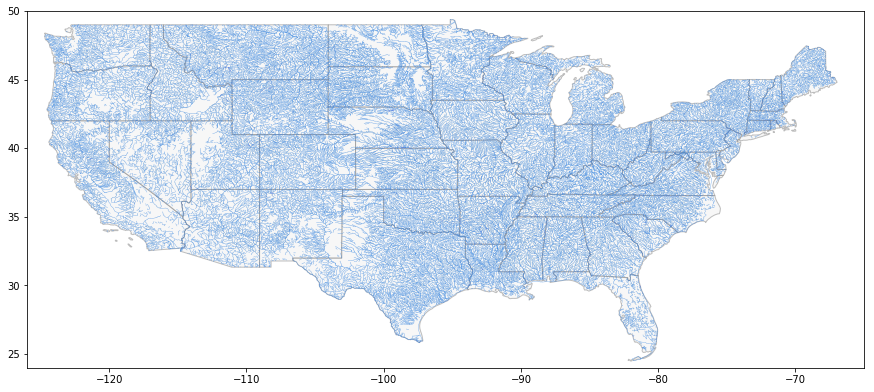

In [10]:
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color
line_color = '#448ee4'
line_width = 0.3

us_states.plot(ax=ax, edgecolor='gray', alpha=0.5, color=base_color)
rivers_raw.plot(ax=ax, color=line_color, linewidth=line_width, zorder=1);
#
ax.set(xlim=(-126,-65), ylim=(24,50));

<a id='zoomplot'></a>
#### Thats alot of water! Does zooming in help?

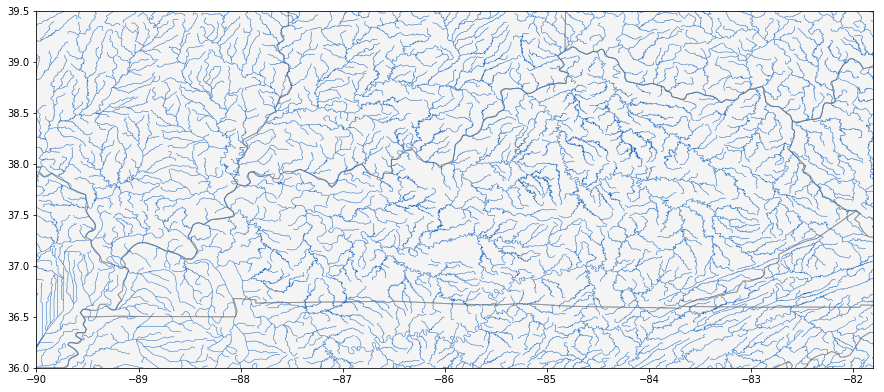

In [11]:
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color
line_color = '#1c68c0'
line_width = 0.5

us_states.plot(ax=ax, edgecolor='gray', alpha=0.7, color=base_color)
rivers_raw.plot(ax=ax, color=line_color, linewidth=line_width, zorder=1);

ax.set(xlim=(-90,-81.8), ylim=(36,39.5));

<a id='infodat'></a>
#### Information about dataframe columns

In [12]:
print('\n\nThere are',rivers_raw['Feature'].nunique(),'unique Features in the dataframe.')
print('And',rivers_raw['F_Code'].nunique(),'unique F_Code in the dataframe.')
print('\nCounts of each Feature')
print('----------------------')
rivers_raw['Feature'].value_counts()



There are 6 unique Features in the dataframe.
And 6 unique F_Code in the dataframe.

Counts of each Feature
----------------------


Stream                   885644
Stream Intermittent      153129
Artificial Path           45578
Canal                      8898
Intracoastal Waterway      1704
Aqueduct                     75
Name: Feature, dtype: int64

<a id='fcode'></a>
#### Unique `Feature` values with corrsponding `F_Code`

In [13]:
unique_fcode = rivers_raw['Feature'].unique()
for index, code in enumerate(unique_fcode):
    print(unique_fcode[index], rivers_raw['F_Code'].loc[rivers_raw['Feature'] == unique_fcode[index]].unique())


Artificial Path [23]
Stream [4]
Stream Intermittent [14]
Canal [5]
Aqueduct [6]
Intracoastal Waterway [8]


<a id='examinestatecol'></a>
#### `State` column in the rivers dataframe contains more than expected 
this is due to the rivers being shared with other states

In [14]:
print(sorted(rivers_raw['State'].unique())) # as the output below shows the rivers can be shared by states

['AK', 'AL', 'AL-FL', 'AL-FL-GA', 'AL-GA', 'AL-LA', 'AL-MS', 'AL-MS-TN', 'AL-TN', 'AR', 'AR-LA', 'AR-MO', 'AR-MO-TN', 'AR-MS', 'AR-OK', 'AR-OK-TX', 'AR-TN', 'AR-TX', 'AZ', 'AZ-CA', 'AZ-CA-NV', 'AZ-NM', 'AZ-NV', 'AZ-UT', 'CA', 'CA-NV', 'CA-OR', 'CO', 'CO-KS', 'CO-NE', 'CO-NM', 'CO-OK', 'CO-UT', 'CO-WY', 'CT', 'CT-MA', 'CT-NY', 'CT-RI', 'DC', 'DC-MD', 'DC-MD-VA', 'DC-VA', 'DE', 'DE-MD', 'DE-PA', 'FL', 'FL-GA', 'GA', 'GA-NC', 'GA-NC-SC', 'GA-SC', 'GA-TN', 'HI', 'IA', 'IA-IL', 'IA-IL-MO', 'IA-IL-WI', 'IA-MN', 'IA-MN-WI', 'IA-MO', 'IA-MO-NE', 'IA-NE', 'IA-NE-SD', 'IA-SD', 'IA-WI', 'ID', 'ID-MT', 'ID-NV', 'ID-OR', 'ID-UT', 'ID-WA', 'ID-WY', 'IL', 'IL-IN', 'IL-IN-KY', 'IL-KY', 'IL-MO', 'IL-WI', 'IN', 'IN-KY', 'IN-KY-OH', 'IN-MI', 'IN-OH', 'KS', 'KS-MO', 'KS-MO-NE', 'KS-NE', 'KS-OK', 'KY', 'KY-MO', 'KY-MO-TN', 'KY-OH', 'KY-OH-WV', 'KY-TN', 'KY-VA', 'KY-VA-WV', 'KY-WV', 'LA', 'LA-MS', 'LA-TX', 'MA', 'MA-NH', 'MA-NH-VT', 'MA-NY', 'MA-RI', 'MA-VT', 'MD', 'MD-PA', 'MD-VA', 'MD-VA-WV', 'MD-WV', 'ME

<a id='focusstate'></a>
#### Focus dataframes on one state

In [15]:
state_df = us_states.loc[us_states['STUSPS'] == 'KY']

__Use the contains method with rivers__  
this gets the "shared" portion of the rivers

In [16]:
rivers_df = rivers_raw.loc[rivers_raw['State'].str.contains('KY')]

<a id='plotdat'></a>
#### Plot the new dataframe

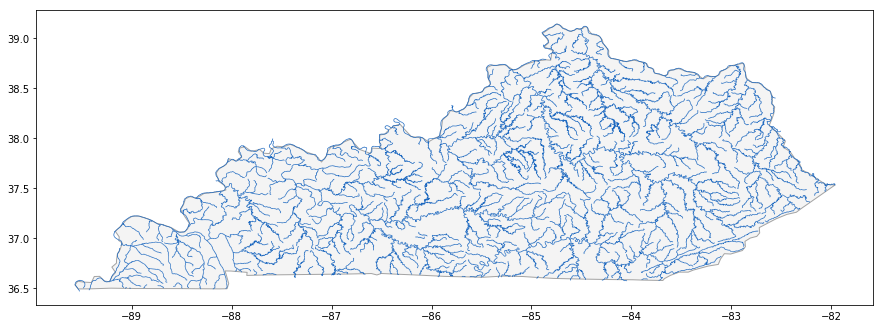

In [17]:
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color
line_color = '#1c68c0'
line_width = 0.7

state_df.plot(ax=ax, edgecolor='gray', alpha=0.7, color=base_color)
rivers_df.plot(ax=ax, color=line_color, linewidth=line_width, zorder=1);


<a id='top20'></a>
#### Top 20 longest rivers

In [18]:
rivers_df_length = rivers_df.groupby(['Name'])['Length_mi'].agg('sum')
rivers_df_length.sort_values(ascending=False).nlargest(20)

Name
Ohio River                    638.910087
Green River                   377.627973
Cumberland River              371.252152
Licking River                 290.802015
Kentucky River                255.585945
North Fork Kentucky River     156.970647
Salt River                    140.683565
Rough River                   139.423881
Barren River                  130.928145
Levisa Fork                   123.755934
Red River                     121.421766
Beech Fork                    119.444316
Tradewater River              114.569528
Rolling Fork                  104.687931
Middle Fork Kentucky River    101.168200
Eagle Creek                   100.718585
Beaver Creek                   97.923336
Nolin River                    97.023088
Tug Fork                       91.754404
Clear Creek                    86.624285
Name: Length_mi, dtype: float64

<a id='simplified'></a>
#### Simplfied method for identifying longest rivers

In [19]:
longest_rivers_name = rivers_df.groupby('Name')['Length_mi'].agg('sum').sort_values(ascending=False).nlargest(10).index

longest_rivers_name

Index(['Ohio River', 'Green River', 'Cumberland River', 'Licking River',
       'Kentucky River', 'North Fork Kentucky River', 'Salt River',
       'Rough River', 'Barren River', 'Levisa Fork'],
      dtype='object', name='Name')

<a id='findlongs'></a>
#### Create a dataframe that only has the longest rivers in it (using: isin)

In [20]:
longest_rivers = rivers_df.loc[rivers_df['Name'].isin(longest_rivers_name)]
longest_rivers.head()

,Stream_ID,Name,Feature,F_Code,State,State_FIPS,Region,ReachCode,ComID,From_node,...,Strahler,Length_mi,GM_f_code,GM_hyc,GM_lit,GM_nam,GM_soc,GM_exs,GM_loc,geometry
153494,10017306,Levisa Fork,Artificial Path,23,KY,21,5,05070202005679,1089125,154617,...,2,0.664634,BH140,8,2,Levisa Fork,USA,-999,-999,LINESTRING Z (-82.36220732199996 37.4202344110...
153504,10017316,Levisa Fork,Artificial Path,23,KY,21,5,05070202005684,1089115,154618,...,2,2.219310,BH140,8,2,Levisa Fork,USA,-999,-999,LINESTRING Z (-82.37007968199998 37.4270989370...
153509,10017321,Levisa Fork,Artificial Path,23,KY,21,5,05070202005682,1089119,154633,...,2,0.355789,BH140,8,2,Levisa Fork,USA,-999,-999,LINESTRING Z (-82.38742505099998 37.4292667500...
169135,10445672,Levisa Fork,Stream,4,KY,21,5,05070202000307,1086719,170453,...,2,0.849094,BH140,8,1,Levisa Fork,USA,-999,-999,LINESTRING Z (-82.42187417899999 37.4122737340...
169141,10445678,Levisa Fork,Stream,4,KY,21,5,05070203000005,886737,170465,...,4,1.572099,BH140,8,1,Levisa Fork,USA,-999,-999,LINESTRING Z (-82.66607515699997 37.9760865050...


<a id='plotlong'></a>
#### Plot the longest rivers over the rivers

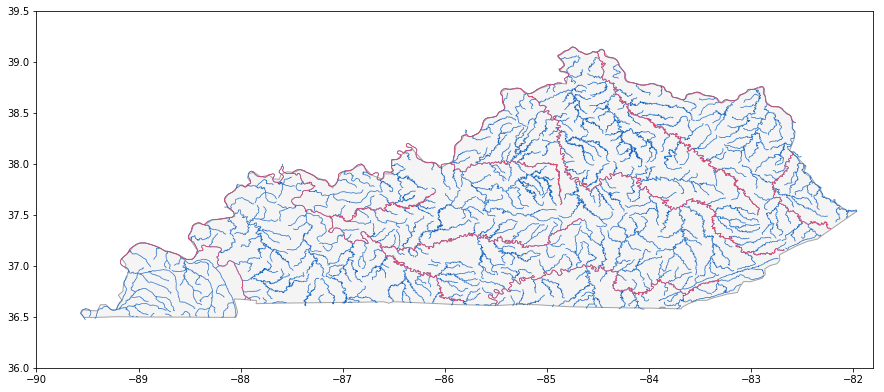

In [21]:
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color
line_color = '#1c68c0'
line_width = 0.7
longriver_color = "#f44262"

state_df.plot(ax=ax, edgecolor='gray', alpha=0.7, color=base_color)
rivers_df.plot(ax=ax, color=line_color, linewidth=line_width, zorder=1);
longest_rivers.plot(ax=ax, color=longriver_color, linewidth=line_width, zorder=2);
ax.set(xlim=(-90,-81.8), ylim=(36,39.5));

<a id='loadtoxic'></a>
### Load toxic data inventory 
from [data.world](https://data.world/dhs/epa-er-toxic-release-inventory)  
point data drawn from the [EPA's toxic release inventory program](https://www.epa.gov/toxics-release-inventory-tri-program)

In [22]:
tri = pd.read_csv('https://query.data.world/s/3b3oi57gti4qhoexmg74sdc3ftz2te', index_col='FID')

In [23]:
tri.head()

,X,Y,REGISTRY_I,PRIMARY_NA,LOCATION_A,CITY_NAME,COUNTY_NAM,FIPS_CODE,STATE_CODE,POSTAL_COD,...,UPDATE_DAT,LAST_REPOR,FAC_URL,PGM_SYS_ID,PGM_SYS_AC,INTEREST_T,ACTIVE_STA,PUBLIC_IND,PROGRAM_UR,PGM_REPORT
FID,,,,,,,,,,,,,,,,,,,,,
15001,-119.86581,34.43024,110002916836,LITTON GUIDANCE AND CONTROL SYSTEMS,6769 HOLLISTER AVENUE,GOLETA,SANTA BARBARA,06083,CA,93117-3001,...,2014-07-31T00:00:00.000Z,2002-06-25T00:00:00.000Z,http://oaspub.epa.gov/enviro/fac_gateway.main?...,93118LTTNS6769H,TRIS,TRI REPORTER,OPEN,Y,http://www.epa.gov/tri/,no data yet
15002,-81.23533,41.75468,110000385921,UNIROYAL CHEMICAL CO INC,720 FAIRPORT NURSERY ROAD,PAINESVILLE,LAKE,39085,OH,44077-4462,...,2014-07-31T00:00:00.000Z,2002-06-24T00:00:00.000Z,http://oaspub.epa.gov/enviro/fac_gateway.main?...,44077NRYLC720FA,TRIS,TRI REPORTER,OPEN,Y,http://www.epa.gov/tri/,no data yet
15003,-83.44870,41.66416,110000384334,AUTONEUM NORTH AMERICA INC,645 N. LALLENDORF RD.,OREGON,LUCAS,39095,OH,43616,...,2014-07-31T00:00:00.000Z,2012-06-29T00:00:00.000Z,http://oaspub.epa.gov/enviro/fac_gateway.main?...,43616GLBND645LA,TRIS,TRI REPORTER,OPEN,Y,http://www.epa.gov/tri/,no data yet
15004,-117.38566,47.75197,110000491478,TRAVIS PATTERN,1413 EAST HAWTHORNE ROAD,SPOKANE,SPOKANE,53063,WA,99218-3100,...,2014-07-31T00:00:00.000Z,2014-05-30T00:00:00.000Z,http://oaspub.epa.gov/enviro/fac_gateway.main?...,99207TRVSPE1413,TRIS,TRI REPORTER,OPEN,Y,http://www.epa.gov/tri/,no data yet
15005,-77.40728,37.58766,110022532623,ENNIS PAINT-RICHMOND,4400 VAWTER AVE,RICHMOND,HENRICO,51087,VA,23222,...,2014-07-31T00:00:00.000Z,2014-06-25T00:00:00.000Z,http://oaspub.epa.gov/enviro/fac_gateway.main?...,23222DGLSC4400V,TRIS,TRI REPORTER,OPEN,Y,http://www.epa.gov/tri/,no data yet


In [24]:
tri.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57630 entries, 15001 to 57000
Data columns (total 27 columns):
X             57630 non-null float64
Y             57630 non-null float64
REGISTRY_I    57630 non-null int64
PRIMARY_NA    57630 non-null object
LOCATION_A    57630 non-null object
CITY_NAME     57630 non-null object
COUNTY_NAM    57630 non-null object
FIPS_CODE     57630 non-null object
STATE_CODE    57630 non-null object
POSTAL_COD    57630 non-null object
LATITUDE83    57630 non-null float64
LONGITUDE8    57630 non-null float64
HUC8_CODE     57630 non-null object
ACCURACY_V    57630 non-null int64
COLLECT_MT    57630 non-null object
REF_POINT_    57630 non-null object
CREATE_DAT    57630 non-null object
UPDATE_DAT    56861 non-null object
LAST_REPOR    57488 non-null object
FAC_URL       57630 non-null object
PGM_SYS_ID    57630 non-null object
PGM_SYS_AC    57630 non-null object
INTEREST_T    57630 non-null object
ACTIVE_STA    57630 non-null object
PUBLIC_IND    57630 n

In [25]:
tri['HUC8_CODE'].unique()


array(['18060013', '04110004', '04100010', ..., '10050004', '14080203',
       '17060203'], dtype=object)

In [26]:
from shapely.geometry import Point

<a id='convertpandas'></a>
#### convert pandas DataFrame into a GeoPandas GeoDataFrame

In [27]:
# create a Series of geometries using the point locations in the dataframe (tri)
geoms = [Point(xy) for xy in zip(tri.X, tri.Y)]
crs = {'init' :'epsg:4326'}
# use GeoPandas to create a GeoDataFrame and assign a CRS
tri_geo = gpd.GeoDataFrame(tri, crs=crs, geometry=geoms)

In [28]:
tri_geo.crs

{'init': 'epsg:4326'}

<a id='plottoxic'></a>
#### plot the GeoPandas dataframe

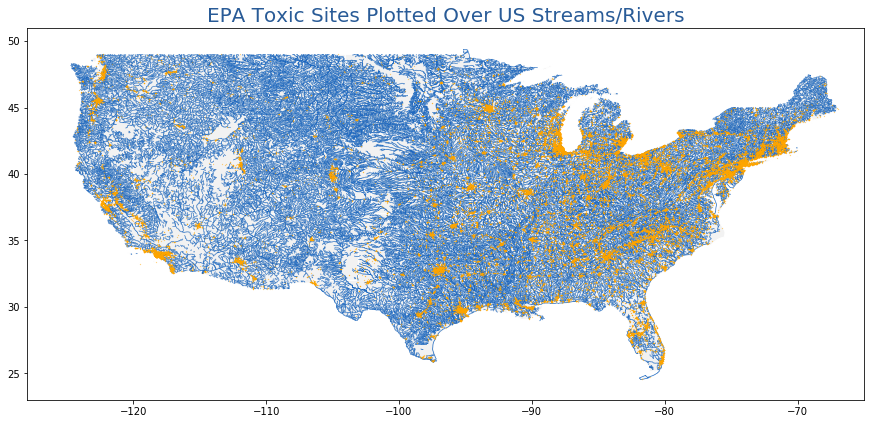

In [29]:
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color
line_color = '#1c68c0'
line_width = 0.7

us_states.plot(ax=ax, edgecolor='white', color='#f2f2f2', zorder=0);
rivers_raw.plot(ax=ax, color=line_color, linewidth=line_width, zorder=1);
tri_geo.plot(ax=ax, color='orange', zorder=2, markersize=.04);

ax.set(xlim=(-128,-65), ylim=(23,51))
plt.title('EPA Toxic Sites Plotted Over US Streams/Rivers', fontsize=20, color='#295b97');

<a id='examineKY'></a>
#### Examine area of Kentucky

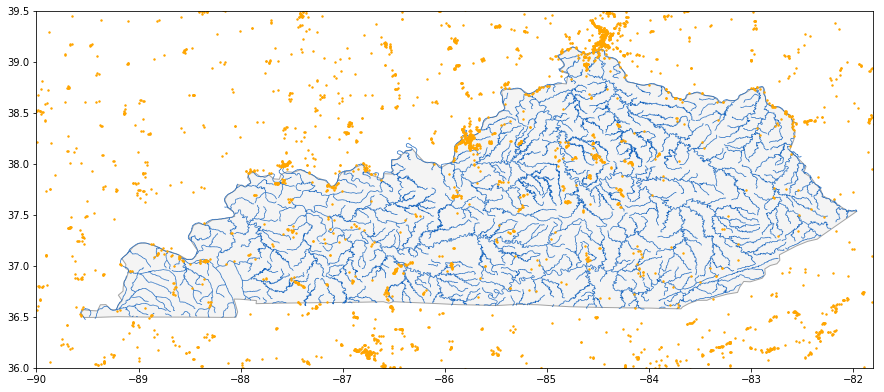

In [30]:
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color
line_color = '#1c68c0'
line_width = 0.7
marker_size = 2

state_df.plot(ax=ax, edgecolor='gray', alpha=0.7, color=base_color)
rivers_df.plot(ax=ax, color=line_color, linewidth=line_width, zorder=1);
tri_geo.plot(ax=ax, color='orange', zorder=2, markersize=marker_size);

ax.set(xlim=(-90,-81.8), ylim=(36,39.5));  # limit the frame to the area of state geodataframe

<a id='clipmaskmain'></a>
### Create a "clipping mask" using the outline of state in state geodataframe
the mask is used to eliminate points outside the state borders

<a id='checkgeom2'></a>
__check if the geom is not composed of both Polygon and Multipolygon types__  
a combination of both creates prolems for GeoPandas

In [31]:
state_df.geom_type.unique()

array(['Polygon'], dtype=object)

In [32]:
rivers_df.geom_type.unique()

array(['LineString'], dtype=object)

<a id='clipmask'></a>
#### create a polygon to be used as a clipping mask  
using the `Shapely .unary_union` method will return a single Shapely Polygon feature

In [33]:
state_poly = state_df.geometry.unary_union

<a id='intersectclip'></a>
#### intersect toxic inventory with state clipping mask
using the `GeoPandas .intersects()` method:

In [34]:
# create new GeoDataFrame of points that intersect with the clipping polygon
state_toxic_places = tri_geo[tri_geo.geometry.intersects(state_poly)]

<a id='plotnewgeo'></a>
### Plot the new geo layers

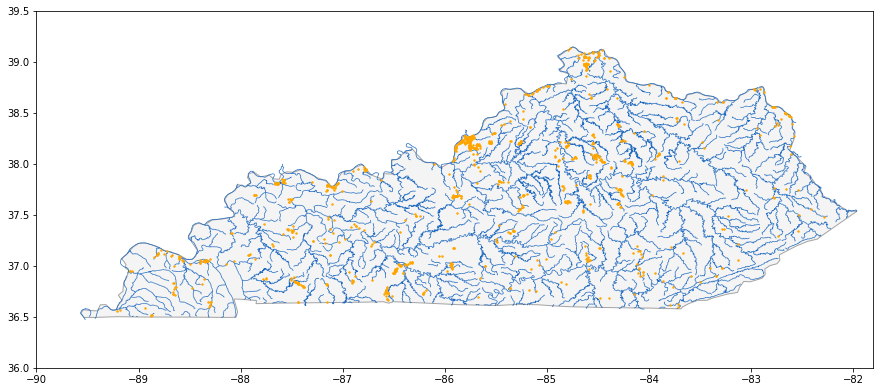

In [35]:
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color
line_color = '#1c68c0'
line_width = 0.7

state_df.plot(ax=ax, edgecolor='gray', alpha=0.7, color=base_color)
rivers_df.plot(ax=ax, color=line_color, linewidth=line_width, zorder=1);
state_toxic_places.plot(ax=ax, color='orange', zorder=2, markersize=2);
ax.set(xlim=(-90,-81.8), ylim=(36,39.5));

<a id='measuredist'></a>
### Prepare the data to measure distance  
__goal is to identify stream possibly impacted my toxic places__  
To solve this, perform some coordinate operations on the datasets and project them to an equidistant conic projection. Use a modified Proj4 string adjusted to center the meridian on the US and minimize distortion between two standard parallels:

In [36]:
state_eqdc = state_df.to_crs('+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
tri_eqdc = state_toxic_places.to_crs('+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
rivers_eqdc = rivers_df.to_crs('+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs ')

<a id='checkplot'></a>
#### check the plot of the reprojected dataframes

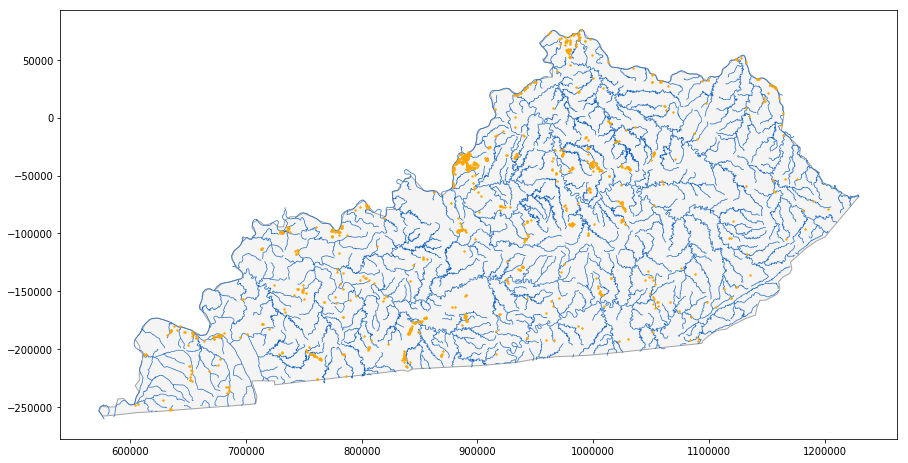

In [37]:
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color
line_color = '#1c68c0'
line_width = 0.7

state_eqdc.plot(ax=ax, edgecolor='gray', alpha=0.7, color=base_color)
rivers_eqdc.plot(ax=ax, color=line_color, linewidth=line_width, zorder=1);
tri_eqdc.plot(ax=ax, color='orange', zorder=2, markersize=2);

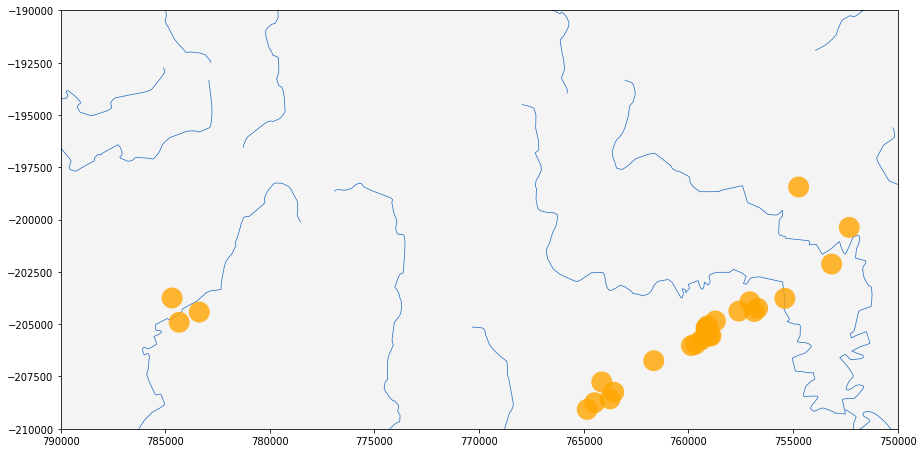

In [133]:
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color
line_color = '#1c68c0'
line_width = 0.7

state_eqdc.plot(ax=ax, edgecolor='gray', alpha=0.7, color=base_color)
rivers_eqdc.plot(ax=ax, color=line_color, linewidth=line_width, zorder=1);
tri_eqdc.plot(ax=ax, color='orange', zorder=2, alpha=0.8, markersize=.5);
ax.set(xlim=(790000,750000), ylim=(-210000,-190000));

<a id='buffercolumn'></a>
### Use `GeoPandas .buffer()` method to create a new column in the existing GeoDataFrame

#### create a new column and assign it the result of the buffer operation  
the result will be in meters

In [39]:
tri_eqdc['buffer'] = tri_eqdc.buffer(500)
# note they are now polygons in meters
tri_eqdc['buffer'].head()

FID
15120    POLYGON ((893863.883211808 -40753.68460501776,...
15209    POLYGON ((910176.5330722714 -25534.61646341437...
15214    POLYGON ((855667.7649079863 -173274.0803310149...
15413    POLYGON ((920363.1437152165 -76393.76624178597...
15425    POLYGON ((891782.4351570779 -35457.18508778657...
Name: buffer, dtype: object

<a id='activategeom'></a>
### make the new buffer column the active geometry to plot the data

In [40]:
print('The current geometry for plots: ' + tri_eqdc.geometry.name)
# set the buffer col as the active geometry
tri_eqdc = tri_eqdc.set_geometry('buffer')
# now the geometry is the buffer column
print('The new geometry for plots: ' + tri_eqdc.geometry.name)

The current geometry for plots: geometry
The new geometry for plots: buffer


<a id='buffercircles'></a>
### Replot with 500 meter buffer circles

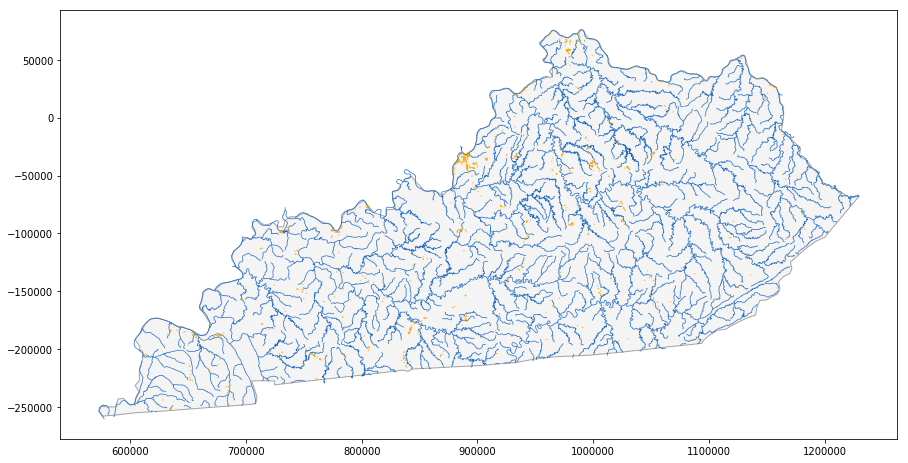

In [114]:
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color
line_color = '#1c68c0'
line_width = 0.7
marker_size = 1

state_eqdc.plot(ax=ax, edgecolor='gray', alpha=0.7, color=base_color)
rivers_eqdc.plot(ax=ax, color=line_color, linewidth=line_width, zorder=1);
tri_eqdc.plot(ax=ax, color='orange', zorder=2, markersize=marker_size);

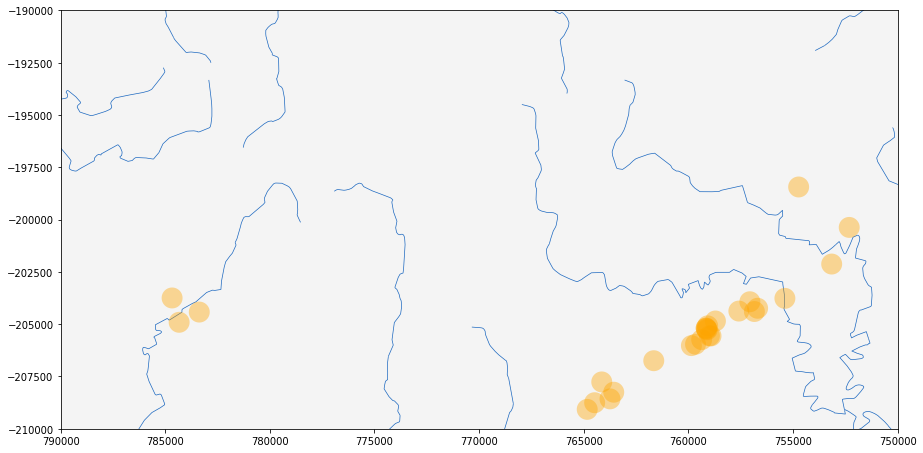

In [42]:
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color
line_color = '#1c68c0'
line_width = 0.7
marker_size = 0.08

state_eqdc.plot(ax=ax, edgecolor='gray', alpha=0.7, color=base_color)
rivers_eqdc.plot(ax=ax, color=line_color, linewidth=line_width, zorder=1);
tri_eqdc.plot(ax=ax, color='orange', zorder=2, alpha=0.4, markersize=marker_size);
ax.set(xlim=(790000,750000), ylim=(-210000,-190000));

<a id='intersect'></a>
### Create Line Polygon Intersection

gpd.sjoin(line_gdf, poly_gdf, op='intersects')

In [109]:
tri_stream_df = gpd.sjoin(tri_eqdc, rivers_eqdc, op='intersects')

In [110]:
tri_stream_df.head()

,X,Y,REGISTRY_I,PRIMARY_NA,LOCATION_A,CITY_NAME,COUNTY_NAM,FIPS_CODE,STATE_CODE,POSTAL_COD,...,Enabled,Strahler,Length_mi,GM_f_code,GM_hyc,GM_lit,GM_nam,GM_soc,GM_exs,GM_loc
5035,-88.39506,37.05202,110000380043,GERDAU AMERISTEEL US INC,1035 SHAR-CAL RD.,CALVERT CITY,MARSHALL,21157,KY,42029,...,1,5,1.991328,BH140,8,1,Tennessee River,USA,-999,-999
5035,-88.39506,37.05202,110000380043,GERDAU AMERISTEEL US INC,1035 SHAR-CAL RD.,CALVERT CITY,MARSHALL,21157,KY,42029,...,1,5,0.363205,BH140,8,1,Tennessee River,USA,-999,-999
5035,-88.39506,37.05202,110000380043,GERDAU AMERISTEEL US INC,1035 SHAR-CAL RD.,CALVERT CITY,MARSHALL,21157,KY,42029,...,1,5,1.667725,BH140,8,1,Tennessee River,USA,-999,-999
5230,-85.92649,36.97383,110003218704,JL FRENCH GLASGOW PLANT #1,20 PRESTWICK DRIVE,GLASGOW,BARREN,21009,KY,42141-8254,...,1,1,3.903664,BH140,8,1,South Fork Beaver Creek,USA,-999,-999
38705,-85.93332,36.97622,110000380515,FEDERAL-MOGUL VSP,20 ABERDEEN ROAD,GLASGOW,BARREN,21009,KY,42141-8238,...,1,1,3.903664,BH140,8,1,South Fork Beaver Creek,USA,-999,-999


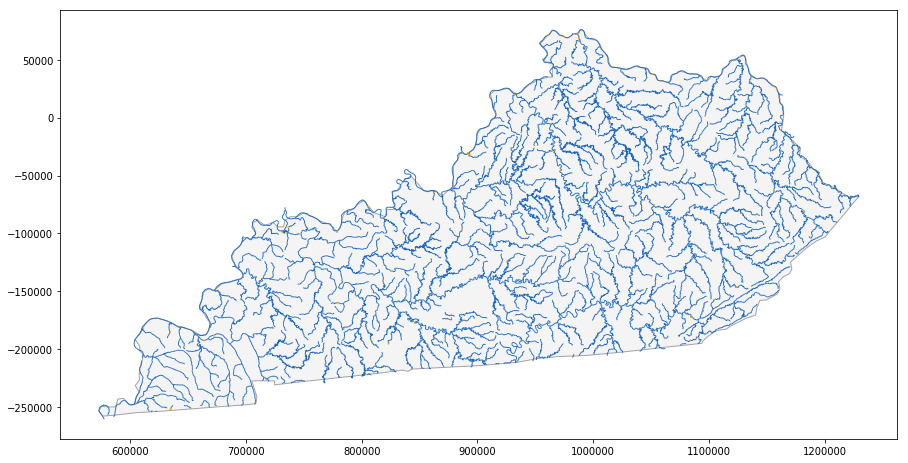

In [132]:
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color
line_color = '#1c68c0'
line_width = 0.9
marker_size = 4

state_eqdc.plot(ax=ax, edgecolor='gray', alpha=0.7, color=base_color)
rivers_eqdc.plot(ax=ax, color=line_color, linewidth=line_width, zorder=1);
tri_stream_df.plot(ax=ax, color='orange', zorder=2, markersize=marker_size);


<a id='closeup'></a>
### Closeup look at buffer poly - line intersections

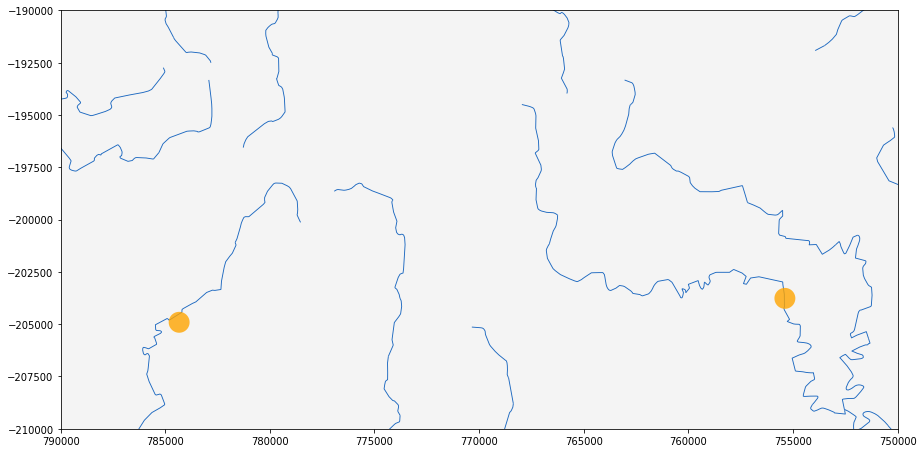

In [115]:
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color
line_color = '#1c68c0'
line_width = 0.9
marker_size = 0.008

state_eqdc.plot(ax=ax, edgecolor='gray', alpha=0.7, color=base_color)
rivers_eqdc.plot(ax=ax, color=line_color, linewidth=line_width, zorder=1);
tri_stream_df.plot(ax=ax, color='orange', zorder=2, alpha=0.8, markersize=marker_size);

ax.set(xlim=(790000,750000), ylim=(-210000,-190000));

<a id='stats'></a>
#### stats before the intersect and after

In [123]:
print('\nBefore the intersect the dataframe tri_eqdc had', tri_eqdc.shape[0], 'rows and', tri_eqdc.shape[1], 'columns\n')
print('The new intersected tri_streams_df has', tri_stream_df.shape[0], 'rows and', tri_stream_df.shape[1], 'columns' )


Before the intersect the dataframe tri_eqdc had 1001 rows and 29 columns

The new intersected tri_streams_df has 185 rows and 51 columns


In [117]:
print(len(tri_stream_df['Name'].unique()), 'unique stream/rivers names have an intersection with a toxic inventory site')

63 unique stream/rivers names have an intersection with a toxic inventory site


<a id='uniquestreamlist'></a>
#### build a list of unique streams that intersect with the buffer

In [118]:
tri_streams_IndexValList = tri_stream_df.index
tri_streams_NameList = tri_stream_df['Name'].tolist()
tri_streams_FromNodeList = tri_stream_df['From_node'].tolist()
tri_streams_ToNodeList = tri_stream_df['To_node'].tolist()

In [119]:
tri_streams=[]
for index in range(len(tri_streams_IndexValList)):
    tri_streams.append([tri_streams_NameList[index], tri_streams_FromNodeList[index], tri_streams_ToNodeList[index]])

In [120]:
tri_streams_unique=[]
tri_streams_unique = [list(x) for x in set(tuple(x) for x in tri_streams)]

In [124]:
print('The list count with duplicates: ', len(tri_streams))
print('The list count without duplicates: ',len((tri_streams_unique)))

The list count with duplicates:  185
The list count without duplicates:  154


<a id='plotportions'></a>
#### Plot the identified stream portions that intersect with the buffer (in progress)

In [ ]:
longest_rivers = rivers_df.loc[rivers_df['Name'].isin(longest_rivers_name)]

In [ ]:
toxic_streams = rivers_eqdc.loc[rivers_eqdc['Name']].isin(tri_streams_unique[0])

<a id='designfunction'></a>
#### Design a function to streamline processing
This function takes a state and highlights its' longest rivers in a plot

In [55]:
def one_state(state_val):
    state_df = us_states.loc[us_states['STUSPS'] == state_val]
    rivers_df = rivers_raw.loc[rivers_raw['State'].str.contains(state_val)]
    longest_rivers_name = rivers_df.groupby('Name')['Length_mi'].agg('sum').sort_values(ascending=False).nlargest(10).index
    print(longest_rivers_name)
    longest_rivers_df = rivers_df.loc[rivers_df['Name'].isin(longest_rivers_name)]
    fig, ax = plt.subplots()

    base_color = '#f0f0f0'
    border_color = base_color
    line_color = '#1c68c0'
    line_width = 0.7
    longriver_color = "#f44262"

    state_df.plot(ax=ax, edgecolor='gray', alpha=0.7, color=base_color)
    rivers_df.plot(ax=ax, color=line_color, linewidth=line_width, zorder=1);
    longest_rivers_df.plot(ax=ax, color=longriver_color, linewidth=line_width, zorder=2);
    #ax.set(xlim=(-90,-81.8), ylim=(36,39.5));
    #return state_df, rivers_df, longest_rivers_df

Index(['Green River', 'Colorado River', 'Sevier River', 'Cottonwood Creek',
       'Willow Creek', 'Bear River', 'Muddy Creek', 'San Juan River',
       'Price River', 'Beaver River'],
      dtype='object', name='Name')


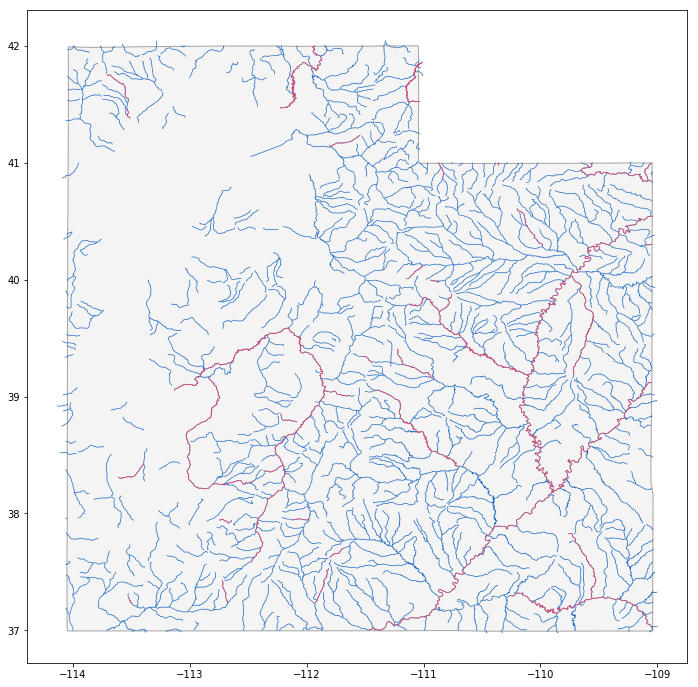

In [56]:
xyz = one_state('UT')